In [2]:
# ---------------------------------------------------------------------
# TikTok preprocessing for regression pipeline
# - Load cleaned dataset
# - Drop irrelevant columns
# - Group rare outlets and create dummies
# - One-hot encode categorical variables
# - Inspect binary features
# - Compute time-based features (days_since_upload)
# - Log / z-transform performance metrics and compute correlations
# - Select final predictors, convert booleans to 0/1 and save
# ---------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------------------------
# 1) Load cleaned dataset
# -------------------------
df = pd.read_csv("tiktok_clean.csv")
df.head()

,V1_coder,V2_video_link,V3_news_outlet,V4_country_of_origin,V5_news_classification,V6_visual_set-up,V7a_images,V7b_text,V7c_screenshots_and_recordings,V7d_graphs_maps_infoanimations,...,M3_create_time,M4_like_count,M5_view_count,M6_comment_count,M7_share_count,M8_hashtags,M4_like_count_log,M5_view_count_log,M6_comment_count_log,M7_share_count_log
0,1,https://www.tiktok.com/share/video/72033756326...,tagesanzeiger,CH,1,1.0,1.0,1.0,0.0,0.0,...,2023-02-16 15:36:28,38.0,680.0,1.0,3.0,"['tagi', 'steuern', 'tagesanzeiger']",3.663562,6.523562,0.693147,1.386294
1,0,https://www.tiktok.com/share/video/72018384221...,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,...,2023-02-12 12:11:22,45.0,521.0,1.0,0.0,"['news', 'tagi', 'teamjorge', 'tagesanzeiger']",3.828641,6.257668,0.693147,0.000000
2,0,https://www.tiktok.com/share/video/71993281044...,tagesanzeiger,CH,1,3.0,0.0,1.0,0.0,1.0,...,2023-02-05 17:50:00,19.0,687.0,0.0,0.0,"['tagi', 'tagesanzeiger', 'regierungsratzh']",2.995732,6.533789,0.000000,0.000000
3,1,https://www.tiktok.com/share/video/71980441179...,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,...,2023-02-02 06:47:34,95.0,1060.0,0.0,0.0,"['schweiz', 'klima', 'wahlen', 'zürich', 'tage...",4.564348,6.966967,0.000000,0.000000
4,1,https://www.tiktok.com/share/video/71963129666...,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,...,2023-01-29 08:00:00,91.0,846.0,2.0,2.0,"['fy', 'fyp', 'tagi', 'tagesanzeiger']",4.521789,6.741701,1.098612,1.098612


In [3]:
# -------------------------
# 2) Drop clearly irrelevant fields
# -------------------------
# coder initials and the video link are not useful for modeling
df = df.drop(columns=['V1_coder', 'V2_video_link'])
df.head()


,V3_news_outlet,V4_country_of_origin,V5_news_classification,V6_visual_set-up,V7a_images,V7b_text,V7c_screenshots_and_recordings,V7d_graphs_maps_infoanimations,V7e_news_brand_elements,V7f_outlet-related_endcard,...,M3_create_time,M4_like_count,M5_view_count,M6_comment_count,M7_share_count,M8_hashtags,M4_like_count_log,M5_view_count_log,M6_comment_count_log,M7_share_count_log
0,tagesanzeiger,CH,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,2023-02-16 15:36:28,38.0,680.0,1.0,3.0,"['tagi', 'steuern', 'tagesanzeiger']",3.663562,6.523562,0.693147,1.386294
1,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,2023-02-12 12:11:22,45.0,521.0,1.0,0.0,"['news', 'tagi', 'teamjorge', 'tagesanzeiger']",3.828641,6.257668,0.693147,0.000000
2,tagesanzeiger,CH,1,3.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2023-02-05 17:50:00,19.0,687.0,0.0,0.0,"['tagi', 'tagesanzeiger', 'regierungsratzh']",2.995732,6.533789,0.000000,0.000000
3,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2023-02-02 06:47:34,95.0,1060.0,0.0,0.0,"['schweiz', 'klima', 'wahlen', 'zürich', 'tage...",4.564348,6.966967,0.000000,0.000000
4,tagesanzeiger,CH,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2023-01-29 08:00:00,91.0,846.0,2.0,2.0,"['fy', 'fyp', 'tagi', 'tagesanzeiger']",4.521789,6.741701,1.098612,1.098612


In [4]:
# -------------------------
# 3) News outlet: group small categories (< 4%) into "other"
# -------------------------
# compute relative frequencies
outlet_props = df['V3_news_outlet'].value_counts(normalize=True)

threshold = 0.04  # outlets below 4% will be grouped
small_outlets = outlet_props[outlet_props < threshold].index

# replace rare outlets with 'other'
df['V3_news_outlet_grouped'] = df['V3_news_outlet'].replace(small_outlets, 'other')

# show new distribution (proportions)
outlet_distribution = (
    df['V3_news_outlet_grouped']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .round(3)
)
print("Grouped outlet distribution (proportions):\n", outlet_distribution)

# drop original outlet variable and add dummies for grouped variable
df.drop(columns=['V3_news_outlet'], inplace=True)
df = pd.get_dummies(df, columns=['V3_news_outlet_grouped'], drop_first=True)

Grouped outlet distribution (proportions):
 V3_news_outlet_grouped
20minuten        0.214
other            0.185
heute.at         0.130
blick            0.087
derstandard      0.053
watson_news      0.053
zeitimbild       0.053
tagesschau       0.048
kleinezeitung    0.046
kurier.at        0.046
srfnews          0.043
rtlaktuell       0.043
Name: proportion, dtype: float64


In [5]:
# -------------------------
# 4) Country of origin: one-hot encode
# -------------------------
df = pd.get_dummies(df, columns=['V4_country_of_origin'], drop_first=True)


In [6]:
# -------------------------
# 5) News classification: single category only => drop
# -------------------------
# After cleaning this variable only contains one category (news-related)
# therefore it carries no variance and is removed.
if 'V5_news_classification' in df.columns:
    df.drop(columns=['V5_news_classification'], inplace=True)

In [7]:
# -------------------------
# 6) Visual set-up: one-hot encode
# -------------------------
# prefix 'visual' keeps column names readable (visual_2.0, visual_3.0, ...)
df = pd.get_dummies(df, columns=['V6_visual_set-up'], prefix='visual', drop_first=True)

# quick check of new visual dummies
print(df.filter(like='visual').columns.tolist())
df.filter(like='visual').head()

['visual_2.0', 'visual_3.0']


,visual_2.0,visual_3.0
0,False,False
1,False,False
2,False,True
3,False,False
4,False,False


In [8]:
# -------------------------
# 7) Inspect binary (0/1) variables frequencies
# -------------------------
binary_vars = [
    'V7a_images','V7b_text','V7c_screenshots_and_recordings',
    'V7d_graphs_maps_infoanimations','V7e_news_brand_elements','V7f_outlet-related_endcard'
]

for col in binary_vars:
    counts = df[col].value_counts(normalize=True) * 100
    print(f"{col} (%):\n{counts}\n")

# Audio variables
audio_vars = [
    'V8a_journalists_moderators_voice','V8b_other_peoples_voice',
    'V8c_voice_other_effect','V8d_music','V8e_ambient'
]

for col in audio_vars:
    counts = df[col].value_counts(normalize=True) * 100
    print(f"{col} (%):\n{counts}\n")

# Interactive variables
interactive_vars = [
    'V9a_mentions','V9b_call_to_interact_on_tiktok','V9c_call_to_interact_outside_of_tiktok'
]

for col in interactive_vars:
    counts = df[col].value_counts(normalize=True) * 100
    print(f"{col} (%):\n{counts}\n")


V7a_images (%):
V7a_images
1.0    54.26577
0.0    45.73423
Name: proportion, dtype: float64

V7b_text (%):
V7b_text
1.0    96.535677
0.0     3.464323
Name: proportion, dtype: float64

V7c_screenshots_and_recordings (%):
V7c_screenshots_and_recordings
0.0    89.193382
1.0    10.806618
Name: proportion, dtype: float64

V7d_graphs_maps_infoanimations (%):
V7d_graphs_maps_infoanimations
0.0    92.657704
1.0     7.342296
Name: proportion, dtype: float64

V7e_news_brand_elements (%):
V7e_news_brand_elements
1.0    89.736298
0.0    10.263702
Name: proportion, dtype: float64

V7f_outlet-related_endcard (%):
V7f_outlet-related_endcard
0.0    78.412616
1.0    21.587384
Name: proportion, dtype: float64

V8a_journalists_moderators_voice (%):
V8a_journalists_moderators_voice
1.0    83.066184
0.0    16.933816
Name: proportion, dtype: float64

V8b_other_peoples_voice (%):
V8b_other_peoples_voice
0.0    74.09514
1.0    25.90486
Name: proportion, dtype: float64

V8c_voice_other_effect (%):
V8c_voice_ot

In [9]:
# -------------------------
# 8) News format: one-hot encode (drop_first to avoid dummy trap)
# -------------------------
df = pd.get_dummies(df, columns=['V10_news_format_type'], prefix='newsformat', drop_first=True)

In [10]:
# -------------------------
# 9) Text: V11_general_topic is free text -> not used for the regression here
# -------------------------
# (We keep it in the dataset but do not encode it for the regression model in this script.)


In [11]:
# -------------------------
# 10) Geographic scope: one-hot encode
# -------------------------
df = pd.get_dummies(df, columns=['V12_geographic_scope'], prefix='geo', drop_first=True)


In [12]:
# -------------------------
# 11) Inspect a few binary content variables (distribution printed)
# -------------------------
for col in ['V13_follow_up','V14_positive_news','V15_negative_news','V16_conflict','V17_scope']:
    print(f"\n{col} distribution (%):")
    print(df[col].value_counts(normalize=True) * 100)


V13_follow_up distribution (%):
V13_follow_up
0.0    99.741468
1.0     0.258532
Name: proportion, dtype: float64

V14_positive_news distribution (%):
V14_positive_news
0.0    93.174767
1.0     6.825233
Name: proportion, dtype: float64

V15_negative_news distribution (%):
V15_negative_news
0.0    75.672182
1.0    24.327818
Name: proportion, dtype: float64

V16_conflict distribution (%):
V16_conflict
0.0    84.022751
1.0    15.977249
Name: proportion, dtype: float64

V17_scope distribution (%):
V17_scope
1.0    83.11789
0.0    16.88211
Name: proportion, dtype: float64


In [13]:
# -------------------------
# 12) Temporal scope: simplify to a binary "current" flag
# -------------------------
# Original codes: 0 = none, 1 = past, 2 = current, 3 = future
df['temporal_current'] = (df['V18_temporal_scope'] == 2).astype(int)
df.drop(columns=['V18_temporal_scope'], inplace=True)

In [14]:
# -------------------------
# 13) Drop ID columns (not predictive)
# -------------------------
df.drop(columns=['M1_video_id', 'M2_music_id'], inplace=True)

Earliest upload: 2022-12-25 14:00:00
Latest upload: 2023-12-24 15:14:16


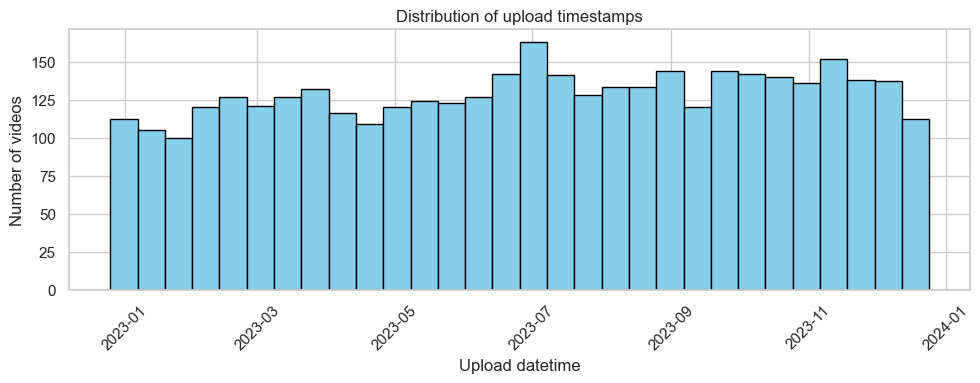

count    3868.000000
mean      174.321872
std       103.080254
min         0.000000
25%        85.000000
50%       171.000000
75%       262.000000
max       363.000000
Name: days_since_upload, dtype: float64


In [15]:
# -------------------------
# 14) Date parsing and derived time feature
# -------------------------
df['M3_create_time'] = pd.to_datetime(df['M3_create_time'], errors='coerce')

# show earliest and latest upload dates
print("Earliest upload:", df['M3_create_time'].min())
print("Latest upload:", df['M3_create_time'].max())

# quick histogram of upload timestamps (visual check)
plt.figure(figsize=(10,4))
plt.hist(df['M3_create_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of upload timestamps')
plt.xlabel('Upload datetime')
plt.ylabel('Number of videos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# reference date used previously (end of collection)
ref_date = pd.to_datetime("2023-12-24")

# compute days since upload and clip negatives to zero
df['days_since_upload'] = (ref_date - df['M3_create_time']).dt.days
df['days_since_upload'] = df['days_since_upload'].clip(lower=0)

# summary for days_since_upload
print(df['days_since_upload'].describe())

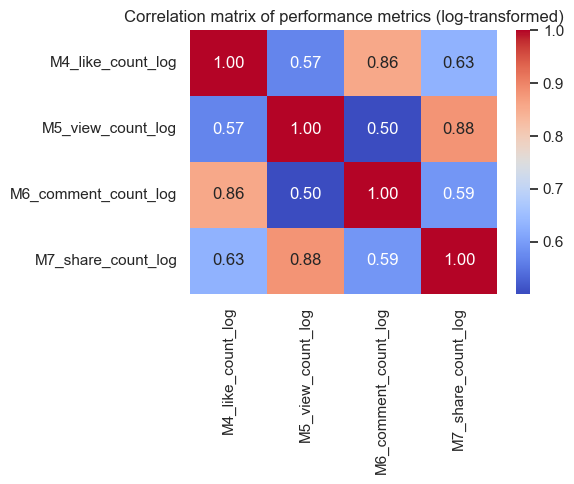

In [16]:
# -------------------------
# 15) Performance metrics: correlation matrix (log versions expected already in df)
# -------------------------
perf_vars = ['M4_like_count_log', 'M5_view_count_log', 'M6_comment_count_log', 'M7_share_count_log']

# ensure columns exist
existing_perf_vars = [v for v in perf_vars if v in df.columns]
if len(existing_perf_vars) < len(perf_vars):
    missing = set(perf_vars) - set(existing_perf_vars)
    print("Warning: some expected log-transformed perf variables are missing:", missing)

corr_matrix = df[existing_perf_vars].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of performance metrics (log-transformed)')
plt.tight_layout()
plt.show()

In [17]:
# -------------------------
# 16) Target transformation: z-standardize the log-view count
# -------------------------
if 'M5_view_count_log' in df.columns:
    df['M5_view_count_log_z'] = (df['M5_view_count_log'] - df['M5_view_count_log'].mean()) / df['M5_view_count_log'].std()
    print(df['M5_view_count_log_z'].describe())
else:
    raise KeyError("M5_view_count_log not found in dataframe. Make sure log transform was applied earlier.")


count    3.868000e+03
mean    -2.020675e-17
std      1.000000e+00
min     -2.364263e+00
25%     -7.588585e-01
50%     -5.751620e-03
75%      8.081366e-01
max      2.651218e+00
Name: M5_view_count_log_z, dtype: float64


In [18]:
# -------------------------
# 17) Final predictor selection and type conversion
# -------------------------
keep_vars = [
    # grouped outlet dummies (these will exist only if those categories are present)
    'V3_news_outlet_grouped_blick', 'V3_news_outlet_grouped_derstandard',
    'V3_news_outlet_grouped_heute.at', 'V3_news_outlet_grouped_kleinezeitung',
    'V3_news_outlet_grouped_kurier.at', 'V3_news_outlet_grouped_other',
    'V3_news_outlet_grouped_rtlaktuell', 'V3_news_outlet_grouped_srfnews',
    'V3_news_outlet_grouped_tagesschau', 'V3_news_outlet_grouped_watson_news',
    'V3_news_outlet_grouped_zeitimbild',
    # country dummies
    'V4_country_of_origin_CH', 'V4_country_of_origin_DE',
    # visual dummies
    'visual_2.0', 'visual_3.0',
    # visual binary features
    'V7a_images','V7b_text','V7c_screenshots_and_recordings',
    'V7d_graphs_maps_infoanimations','V7e_news_brand_elements','V7f_outlet-related_endcard',
    # audio
    'V8a_journalists_moderators_voice','V8b_other_peoples_voice',
    'V8c_voice_other_effect','V8d_music','V8e_ambient',
    # interactive
    'V9a_mentions','V9b_call_to_interact_on_tiktok','V9c_call_to_interact_outside_of_tiktok',
    # news format dummies
    'newsformat_2.0','newsformat_3.0','newsformat_4.0',
    # geo dummies
    'geo_1.0','geo_2.0',
    # content flags
    'V13_follow_up','V14_positive_news','V15_negative_news',
    'V16_conflict','V17_scope',
    # temporal + time-since
    'temporal_current','days_since_upload',
    # target
    'M5_view_count_log_z'
]

# Keep only variables that actually exist in df (avoid KeyError)
keep_vars_existing = [v for v in keep_vars if v in df.columns]
missing_keep = set(keep_vars) - set(keep_vars_existing)
if missing_keep:
    print("Note: the following desired predictors were not found and will be skipped:", missing_keep)

df_reg = df[keep_vars_existing].copy()

# Convert boolean columns to integers (0/1) if any booleans remain
bool_cols = df_reg.select_dtypes(include='bool').columns
if len(bool_cols) > 0:
    df_reg[bool_cols] = df_reg[bool_cols].astype(int)

# final dtype check
print("Final dataframe dtypes:\n", df_reg.dtypes.value_counts())
print(df_reg.head())

Final dataframe dtypes:
 int64      22
float64    20
Name: count, dtype: int64
   V3_news_outlet_grouped_blick  V3_news_outlet_grouped_derstandard  \
0                             0                                   0   
1                             0                                   0   
2                             0                                   0   
3                             0                                   0   
4                             0                                   0   

   V3_news_outlet_grouped_heute.at  V3_news_outlet_grouped_kleinezeitung  \
0                                0                                     0   
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
4                                0                                     0   

   V3_news_outlet_grouped_kurier.at  

In [19]:
# -------------------------
# 18) Save regression-ready file
# -------------------------
df_reg.to_csv("tiktok_regression_ready.csv", index=False)
print("Saved: tiktok_regression_ready.csv")

Saved: tiktok_regression_ready.csv
